<h3><b>Dollar Cost Average Trading Strategy</b></h3>
<p> Dollar cost averaging is one of the most popular strategies for buy-and-hold investors. Essentially, it involves buying a predetermined notional amount of an asset at specific intervals with no regard for where the price is at. By dollar cost averaging over a long enough time horizon, you'll be exposing yourself to all the troughs and peaks of the market cycle, with the hope that eventually the trend will be up and to the right.</p>

In [1]:
# Import Dependencies
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import quantstats as qs
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Instantiate REST API
API_KEY=""
SECRET_KEY=""
endpoint = 'https://paper-api.alpaca.markets'
rest_api = tradeapi.REST(API_KEY, SECRET_KEY, endpoint, api_version='v2')

In [3]:
# Define symbol, start, and end dates
symbol = "AAPL"
num_of_years = 1
start_date = "2022-01-01"
end_date = "2022-12-31"

# Retrieve historical pricing for stock
barset = {}
barset[symbol] = rest_api.get_bars(symbol, TimeFrame.Day, start_date, end_date).df
data = barset[symbol]
data_price = data['close']
data

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 05:00:00+00:00,177.83,182.8800,177.71,182.010,104689466,772366,181.415520
2022-01-04 05:00:00+00:00,182.64,182.9400,179.12,179.700,99433260,831617,180.553940
2022-01-05 05:00:00+00:00,179.61,180.1700,174.65,174.835,86753605,844517,177.497780
2022-01-06 05:00:00+00:00,172.70,175.3000,171.64,172.000,96792589,958688,173.079885
2022-01-07 05:00:00+00:00,172.89,174.1400,171.03,172.170,87682412,716118,172.439116
...,...,...,...,...,...,...,...
2022-12-23 05:00:00+00:00,130.92,132.4150,129.64,131.860,63826892,541275,131.152093
2022-12-27 05:00:00+00:00,131.38,131.4100,128.72,130.030,69007830,608331,129.952171
2022-12-28 05:00:00+00:00,129.67,131.0275,125.87,126.040,85440007,762246,127.591763


In [4]:
# Simulate Historical Lump Sum Investing
def lumpsum_simulation(invest_date, principal=10000):
    invest_price = data.loc[invest_date]['close']
    current_price = data['close'][-1]
    investment_return = (current_price / invest_price) - 1

    return principal*(1+investment_return)

In [5]:
# Simulate Historical Dollar Cost Averaging
def dca_simulation(invest_date, periods=(12*num_of_years), freq='30D', principal=10000):
    dca_dates = pd.date_range(invest_date, periods=periods, freq=freq)
    dca_dates = dca_dates[dca_dates < data.index[-1]]

    cut_off_count = 12 - len(dca_dates)
    value = cut_off_count*(principal/periods)

    for date in dca_dates:
        trading_date = data.index[data.index.searchsorted(date)]
        value += lumpsum_simulation(trading_date, principal=principal/periods)
    return value

In [6]:
# Create array of portfolio values from lump sum, dca, and the difference between the two
lump_sum = [lumpsum_simulation(x) for x in data.index]
dca = [dca_simulation(i) for i in data.index]
difference = np.array(lump_sum) - np.array(dca)

# Print statistics on how often Lump Sum Investing beat Dollar Cost Averaging
print("Lump Sum Investing Beats Dollar Cost Averaging {:.2f}% of the time".format((100*sum(difference>0)/len(difference))))

Lump Sum Investing Beats Dollar Cost Averaging 7.17% of the time


                           Strategy
-------------------------  ----------
Start Period               2022-01-04
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -28.61%
CAGR﹪                     -21.02%

Sharpe                     -0.77
Prob. Sharpe Ratio         22.24%
Smart Sharpe               -0.76
Sortino                    -1.09
Smart Sortino              -1.06
Sortino/√2                 -0.77
Smart Sortino/√2           -0.75
Omega                      0.88

Max Drawdown               -29.86%
Longest DD Days            360
Volatility (ann.)          35.66%
Calmar                     -0.7
Skew                       0.33
Kurtosis                   1.08

Expected Daily %           -0.13%
Expected Monthly %         -2.77%
Expected Yearly %          -28.61%
Kelly Criterion            -6.35%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.81%
Expected Shortfall (cVaR)  -3.81%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-05,2022-12-28,2022-12-30,360,-29.860879,-27.640512


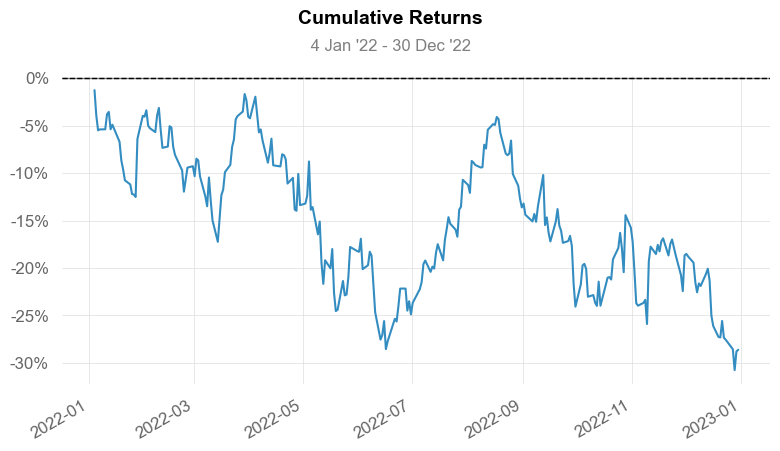

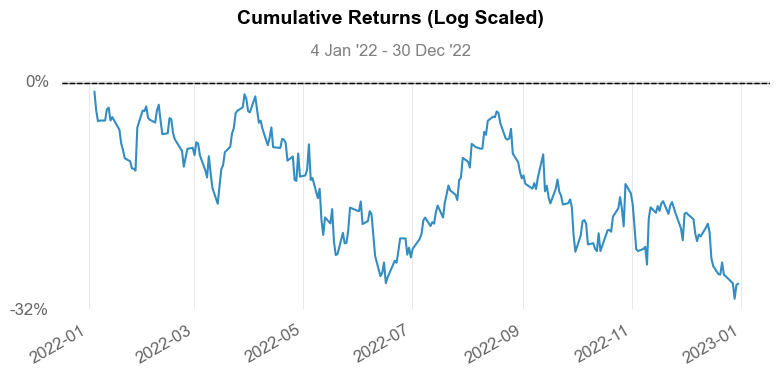

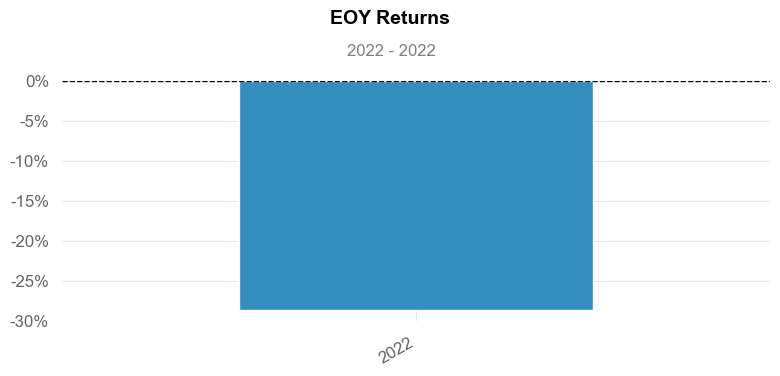

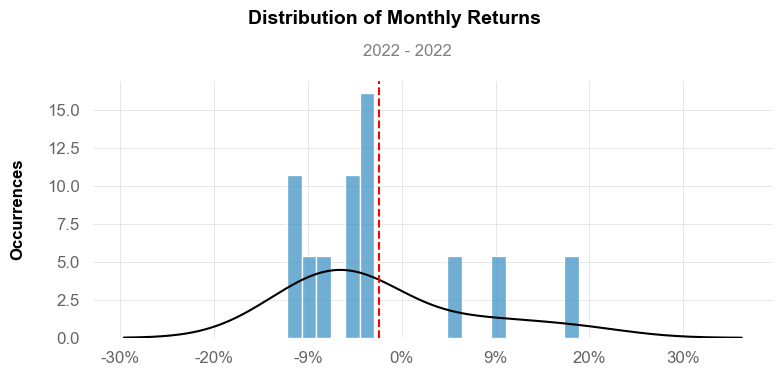

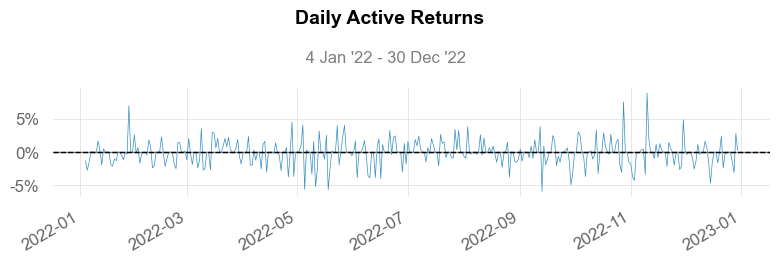

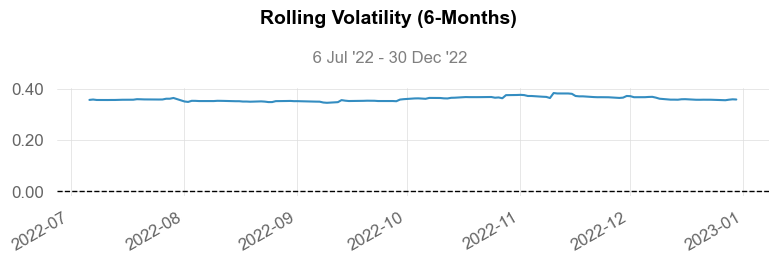

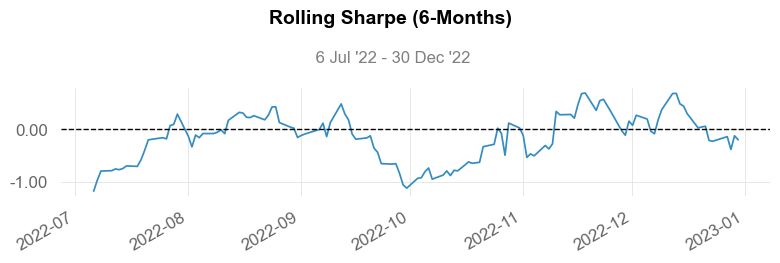

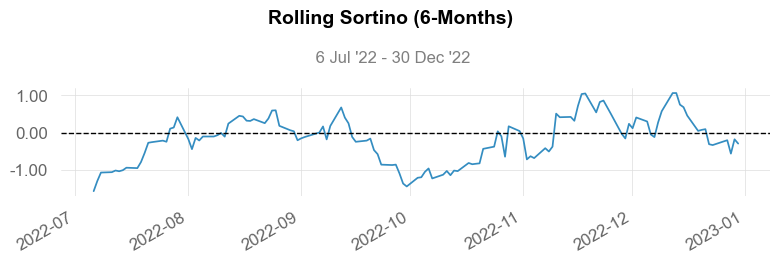

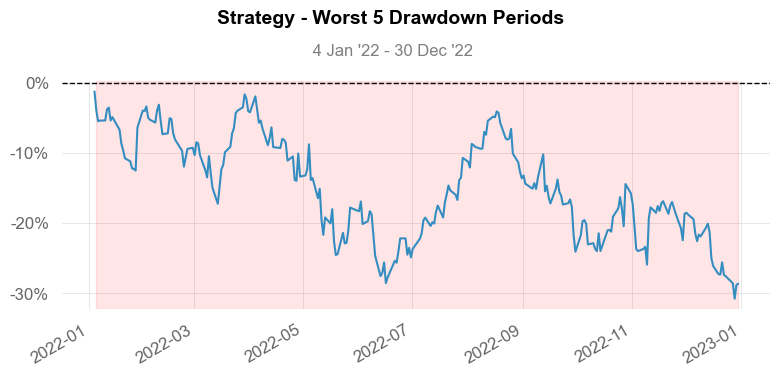

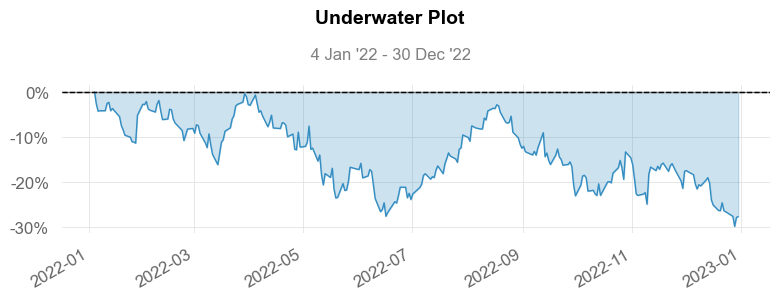

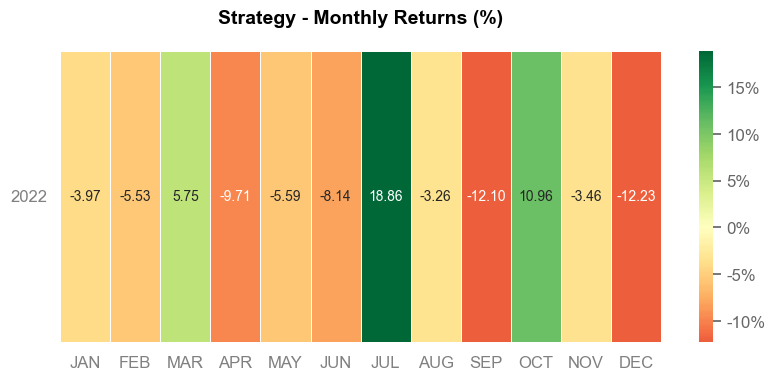

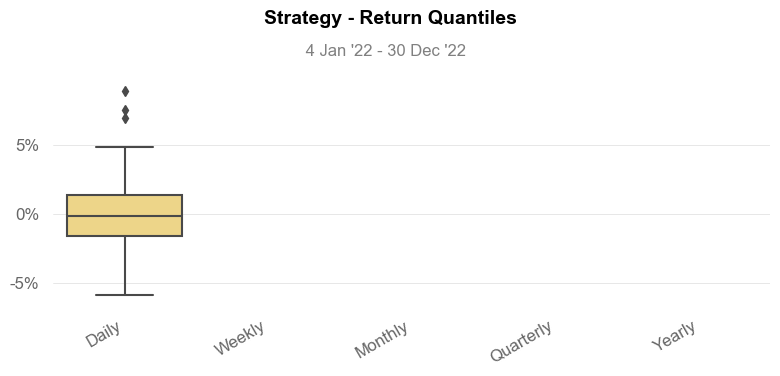

In [7]:
qs.extend_pandas()
returns = pd.Series(data['close'].pct_change().dropna().values, index=pd.to_datetime(data.index[1:]).to_numpy(dtype='datetime64[ns]'))
formatted_index = returns.index.strftime('%Y-%m-%d %H:00')
returns = pd.Series(returns.values, index=formatted_index)
returns.index = pd.to_datetime(returns.index)
qs.reports.full(returns)

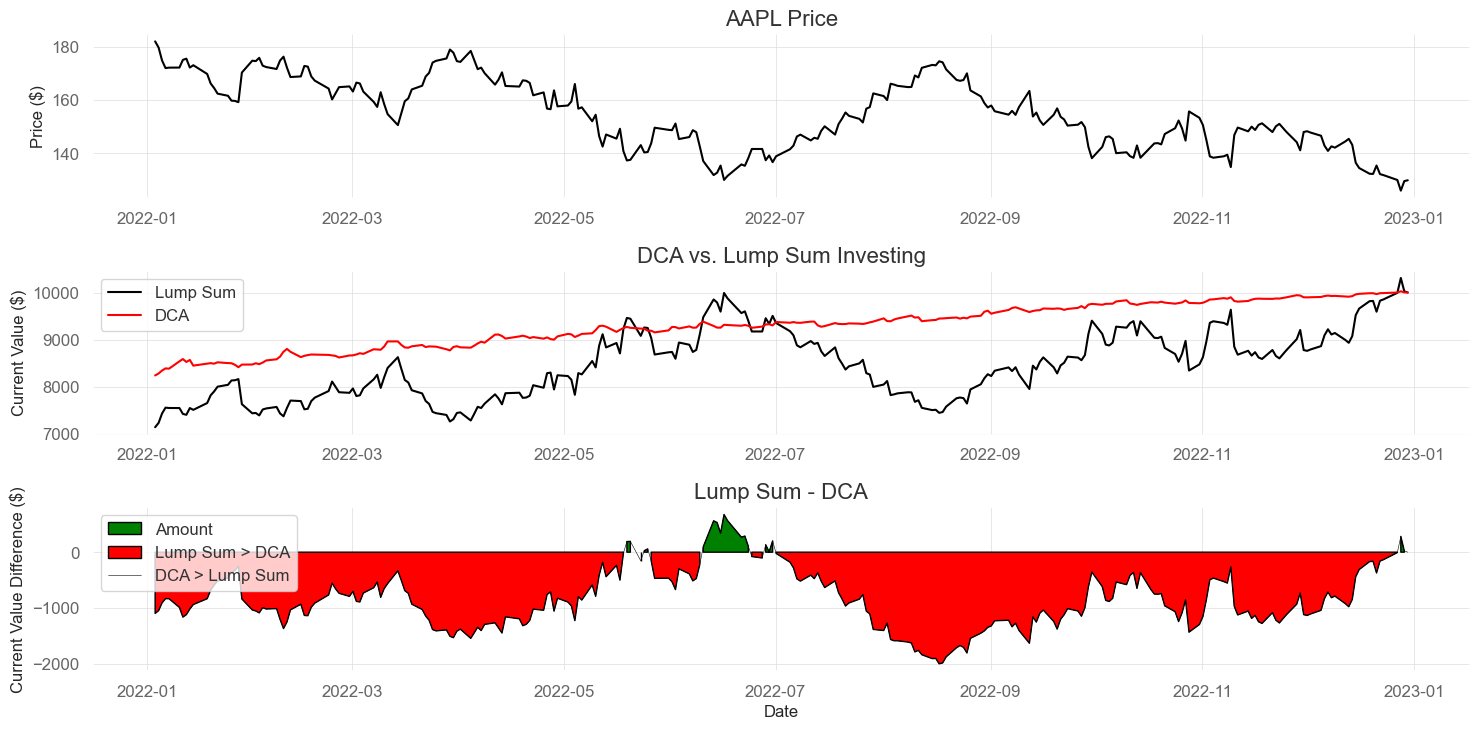

In [8]:
# Plot crypto price, LS vs. DCA, and difference of returns
plt.rcParams['figure.figsize'] = 15, 7.5
fig, (ax1, ax2, ax3) = plt.subplots(3)

# Plotting stock price
ax1.plot(data.index, data_price, color='black')
ax1.set_title(f'{symbol} Price', size=16)
ax1.set_ylabel('Price ($)', size=12)

# Plotting LS vs DCA equity curves
ax2.plot(data.index, lump_sum, color='black')
ax2.plot(data.index, dca, color='red')
ax2.set_title('DCA vs. Lump Sum Investing', size=16)
ax2.set_ylabel('Current Value ($)', size=12)
ax2.legend(['Lump Sum', 'DCA'])

# Plotting difference between LS and DCA equity curves
ax3.fill_between(data.index, y1=difference, y2=0, color='green', where=difference > 0, edgecolor='black')
ax3.fill_between(data.index, y1=difference, y2=0, color='red', where=difference < 0, edgecolor='black')
ax3.plot(data.index, difference, color='black', linewidth=.4)
ax3.set_title('Lump Sum - DCA', size=16)
ax3.set_ylabel('Current Value Difference ($)', size=12)
ax3.set_xlabel('Date', size=12)
ax3.legend(['Amount','Lump Sum > DCA', 'DCA > Lump Sum'])
fig.tight_layout()
plt.show()

In [9]:
# Retrieve Account Cash Balance (can only use non marginable buying power for stock assets)
def get_cash_balance():
    cash = rest_api.get_account().non_marginable_buying_power
    return cash

In [10]:
# Get current price for stock
def get_current_price(symbol):
    price = (rest_api.get_bars(symbol, TimeFrame.Minute)).df["close"][-1]
    return price

In [11]:
# Place buy order through Alpaca API
def place_buy_order(quantity, symbol):
    rest_api.submit_order(symbol=symbol, qty=quantity, type="market", side="buy", time_in_force="day")
    return

In [12]:
# Function to place orders when dollar cost averaging
def dollar_cost_average(symbol, position_size):
    try:
        currentPrice = float(get_current_price(symbol))
        print(f"\nThe current price for {symbol} is {currentPrice}")

        cash = float(get_cash_balance())
        print(f"The current cash balance available is {cash}")

        if cash > position_size:
            quantity = float(round(position_size / currentPrice, 3))
            print(f"{symbol} Buy Quantity: {quantity}")
            place_buy_order(quantity, symbol)

            time.sleep(1)
            print(f"The new cash balance is {get_cash_balance()}")
        else:
            print("Insufficient funds for full position")

            quantity = float(round((cash / currentPrice) * 0.95, 3))
            print(f"{symbol} Buy Quantity: {quantity}")
            place_buy_order(quantity, symbol)

            time.sleep(1)
            print(f"The new cash balance is {get_cash_balance()}")

        return {"Success": True}

    except Exception as e:
        print(e)
        return {"Success": False}

In [13]:
# User input for timeframe, position sizing, stockcurrency
timeframe = input("Enter DCA time frame (day, week, month): " )
position_size = float(input(f"Enter many dollars you want to buy of {symbol} per interval: "))

timeframe_to_seconds = {
    "day": 86400,
    "week": 604800,
    "month": 2629746
}

print(f"You have chosen to dollar cost average {position_size} of {symbol} every {timeframe}")

# Set up while statement to run DCA bot
while True:
    dollar_cost_average(symbol, position_size)
    time.sleep(timeframe_to_seconds[timeframe.lower()])

You have chosen to dollar cost average 1000.0 of AAPL every 26 6 6

The current price for AAPL is 186.5
The current cash balance available is 93700.74
AAPL Buy Quantity: 5.362
The new cash balance is 93200.5


KeyError: '26 6 6'